# Create a Mathematical Preference Dataset with `distilabel`

_Authored by: David Berenstein and Sara Han Díaz from [Argilla](https://github.com/argilla-io/argilla)_


In this tutorial, you will learn how to use different Mistral models to create a mathematical preference synthetic dataset with `distilabel`.

> [distilabel](https://github.com/argilla-io/distilabel/tree/main) is an AI Feedback (AIF) framework that can generate and label datasets using LLMs and can be used for many different use cases. Implemented with robustness, efficiency, and scalability in mind, it allows anyone to build their synthetic datasets that can be used in many different scenarios.

With **distilabel** you can build a `Pipeline` with the different steps you need that will be connected as nodes in a Direct Acyclic Graph (DAG). In this tutorial, we will generate some instructions using the self-instruct approach and then will generate two possible answers using MistralAI models. Then, we will use a higher-level model to judge the answers (`mistral-large`). Finally, we will use the `argilla` package to analyze the dataset and push it to HF. Consult [here](https://huggingface.co/datasets/sdiazlor/math-preference-dataset) an example of the dataset we will create.

We will follow these steps:

* Indicate the seed data.
* Define the building blocks of our `Pipeline`.
* Run the pipeline.
* (Optional) Use **argilla** to annotate/analyze the dataset.

## Getting Started

We should start by installing the required dependencies to run **distilabel**. We will need also some extras: the `mistralai` integration to generate our data and the `argilla` package to analyze the dataset.

In [ ]:
!pip install distilabel[mistralai,argilla]==1.1.1

Now, let's make the needed imports!

In [2]:
from distilabel.llms import MistralLLM
from distilabel.pipeline import Pipeline
from distilabel.steps import ExpandColumns, LoadDataFromDicts, CombineColumns, PreferenceToArgilla
from distilabel.steps.tasks import TextGeneration, UltraFeedback, SelfInstruct
from distilabel.steps.formatting.dpo import FormatTextGenerationDPO

You'll also need an API key from MistralAI to use their models. You can get one by logging in [MistralAI](https://mistral.ai/) and activating one in `API Keys`.

In addition, if you want to visualize and annotate your data with `argilla`, you'll need to run a [Hugging Face Space](https://huggingface.co/new-space?template=argilla/argilla-template-space) where the dataset will be pushed. For more information, check the [Argilla documentation](https://docs.argilla.io/en/latest/getting_started/quickstart_installation.html). Once set up, you'll need to indicate the `ARGILLA_API_URL` (built as `https://[your-owner-name]-[your_space_name].hf.space`) and `ARGILLA_API_KEY` (once in the Space you can find it in My Settings).


> To make sure that they are not leaked, you can set them as an environment variable in your system or if you're using Google Colab, we recommend you add it as a secret.

In [ ]:
import os

# Environment variable
os.environ['MISTRAL_API_KEY'] = '<MISTRAL_API_KEY>'
os.environ['ARGILLA_API_URL'] = '<ARGILLA_API_URL>'
os.environ['ARGILLA_API_KEY'] = '<ARGILLA_API_KEY>'

# Environment variable in Google Colab with secrets
os.environ['MISTRAL_API_KEY'] = userdata.get('MISTRAL_API_KEY')
os.environ['ARGILLA_API_URL'] = userdata.get('ARGILLA_API_URL')
os.environ['ARGILLA_API_KEY'] = userdata.get('ARGILLA_API_KEY') # by default, owner.apikey

## Indicate the Seed Data

First, we will indicate our seed data, a list of mathematical topics, to create the instructions. However, for introductory purposes, we will just use the first 10 samples. Feel free to change this number to generate more or less data.

In [ ]:
math_topics = [
    "Algebraic Expressions",
    "Linear Equations",
    "Quadratic Equations",
    "Polynomial Functions",
    "Rational Expressions",
    "Exponential Functions",
    "Logarithmic Functions",
    "Sequences and Series",
    "Matrices",
    "Determinants",
    "Complex Numbers",
    "Trigonometry",
    "Geometry",
    "Coordinate Geometry",
    "Vector Algebra",
    "Statistics",
    "Probability",
    "Calculus",
    "Differential Calculus",
    "Integral Calculus",
    "Limits and Continuity",
    "Differentiation",
    "Integration",
    "Theorems of Calculus",
    "Mathematical Reasoning",
    "Set Theory",
    "Number Theory",
    "Permutations and Combinations",
    "Binomial Theorem",
    "Arithmetic Progressions",
    "Geometric Progressions",
    "Harmonic Progressions",
    "Trigonometric Ratios",
    "Trigonometric Identities",
    "Inverse Trigonometric Functions",
    "Hyperbolic Functions",
    "Conic Sections",
    "Circle Geometry",
    "Ellipse Geometry",
    "Parabola Geometry",
    "Hyperbola Geometry",
    "Function Theory",
    "Graph Theory",
    "Differential Equations",
    "Mathematical Induction",
    "Discrete Mathematics",
]

data=[{"input": topic} for topic in math_topics[:10]]

## Defining the Building Blocks

> For more information, consult the general documentation [here](https://distilabel.argilla.io/latest/).
> * [Pipeline documentation](https://distilabel.argilla.io/latest/sections/learn/tutorial/pipeline/)
> * [Steps documentation](https://distilabel.argilla.io/latest/sections/learn/tutorial/step/)
> * [Tasks documentation](https://distilabel.argilla.io/latest/sections/learn/tutorial/task/)
> * [LLMs documentation](https://distilabel.argilla.io/latest/sections/learn/tutorial/llm/)

In this case, we will create a `Pipeline` by making use of the context manager, giving it the name `mistral-pipe` and adding a description. Below, we will detail each step:

1. `load_dataset`: This step will load our data which is a list of dictionaries. The input and output columns will be the same, `input`.
2. `self_instruct_open_mistral`: `SelfInstruct` is a pre-defined task that, given a number of instructions, certain criteria for query generations, an application description, and an input, generates new queries. We will use the default criteria and `open-mistral-7b`. The input column is `input` and the output columns are `instructions` (a list of instructions for each input. Default to 5.) and `model_name`.
3. `expand_columns`: As we want to generate the answers, we need to use each instruction in the list of `instructions` individually. This step will expand the `instructions` column into multiple rows under `instruction`.
4. `generate_open-mistral-7b` and `generate_open-mixtral-8x7b`: Now, we will use two different open-source models (`open-mistral-7b` and `open-mixtral-8x7b`) to generate the answers using the basic `TextGeneration` task. We will run both at once. The input column for each step is `instruction` and the output columns are `generation` and `model_name`.
5. `combine_generations`: We will combine the generations and names from both models into a single column `generations`.
6. `ultrafeedback_mistral-large-latest`: Finally, we will use the close model `mistral-large` model to judge the answers using the `UltraFeedback` and indicating that we want an `overall-rating`, instead of focusing on a special one. The input columns are `input` and `generations` and the output columns are `ratings`, `rational` and `model_name`.
7. (optional) `to_argilla`: You can send this data to be annotated as preference data to `argilla` so that the data quality can be improved. The required columns are `input`, `model_names`, `instructions`, `instruction`, `generations`, `model_name`, `ratings` and `rationales`. As mentioned above, you'll need to have a running [Hugging Face Space](https://huggingface.co/new-space?template=argilla/argilla-template-space) where the dataset will be pushed and visualized.
8. `format_dpo`: Using `FormatTextGenerationDPO`, we can easily prepare our dataset for DPO with the `chosen` and `rejected` columns.

Finally, the only thing left is to connect the above steps with `>>`.

> If you prefer to skip the `to_argilla` step, you can comment it in the pipeline and remove it from the connected steps.

In [5]:
with Pipeline(name="mistral-pipe", description="A pipeline to generate and score a distiset") as pipeline:

    load_dataset = LoadDataFromDicts(
        name= "load_dataset", data=data,
    )

    self_instruct_open_mistral = SelfInstruct(
        name="self_instruct_open_mistral", llm=MistralLLM(model="open-mistral-7b"),
    )

    expand_columns = ExpandColumns(
        name="expand_columns", columns={"instructions": "instruction"}
    )

    tasks = []
    for llm in (MistralLLM(model="open-mistral-7b"),
                MistralLLM(model="open-mixtral-8x7b")
                ):
        tasks.append(
            TextGeneration(name=f"generate_{llm.model_name}", llm=llm)
        )

    combine_generations = CombineColumns(
            name="combine_generations",
            columns=["generation", "model_name"],
            output_columns=["generations", "model_names"],
    )

    ultrafeedback_mistral_large = UltraFeedback(
        name= "ultrafeedback_mistral_large", llm=MistralLLM(model="mistral-large-latest"), aspect="overall-rating"
    )

    to_argilla = PreferenceToArgilla(
        dataset_name="mathematical-dataset",
        dataset_workspace="admin", # by default
        num_generations=2
    )

    format_dpo = FormatTextGenerationDPO(name="format_dpo")


    load_dataset >> self_instruct_open_mistral >> expand_columns >> tasks >> combine_generations >> ultrafeedback_mistral_large >> [to_argilla, format_dpo]

## Run the Pipeline

Finally, we will run the pipeline with the `run` method. You can set some runtime parameters to further customize each step. Take into account that the complete run will take around 10 minutes.

> To test the pipeline, instead of `run`, you can use the `dry_run` method that will use a single batch.

In [ ]:
distiset = pipeline.run(
    parameters={
        "generate_open-mistral-7b": {
            "llm": {
                "generation_kwargs": {
                    "max_new_tokens": 512,
                    "temperature": 0.7,
                }
            }
        },
        "generate_open-mixtral-8x7b": {
            "llm": {
                "generation_kwargs": {
                    "max_new_tokens": 512,
                    "temperature": 0.7,
                }
            }
        }
    }
)


And that's it! You have created a synthetic dataset with MistralAI models using `distilabel`.

In [ ]:
distiset

🤗 Push the dataset to HF and share it!

In [ ]:
distiset.push_to_hub(repo_id="<repository_name>/math-preference-dataset")

If you have added it to Argilla, start the annotation process and improve the dataset quality.

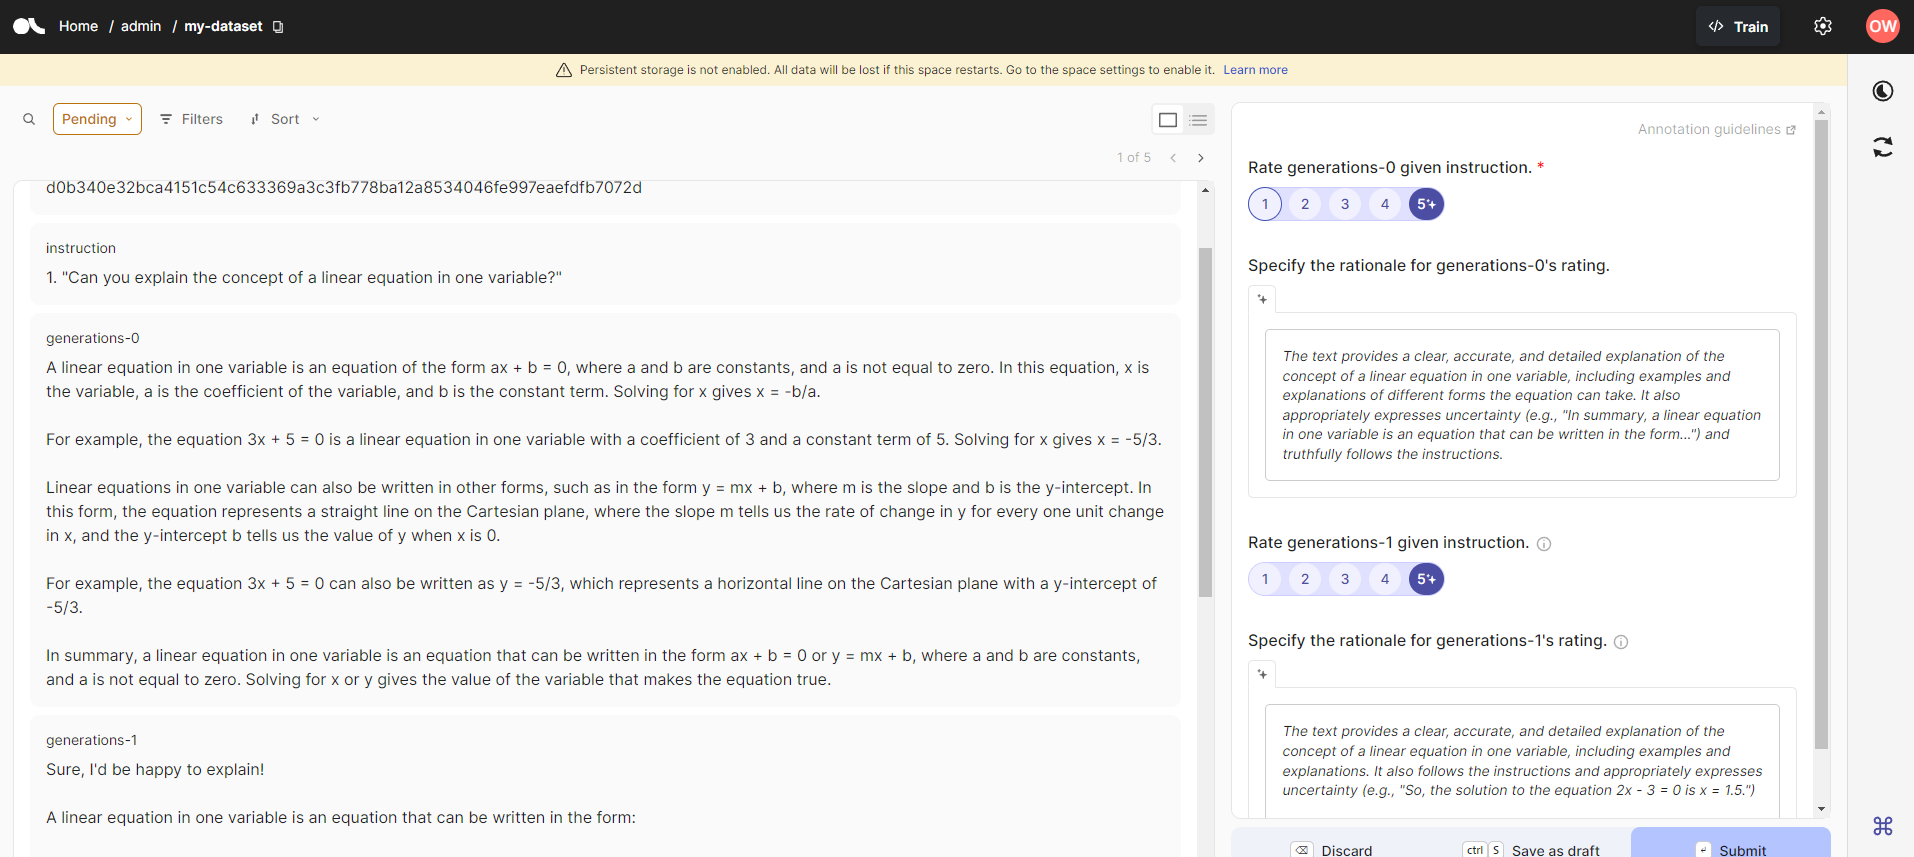

## Conclusion

In this tutorial, we have learned how to create a synthetic dataset using MistralAI models with `distilabel`. We have used the `self_instruct` task to generate instructions and then used two different MistralAI models to generate the answers. Finally, we have used the `mistral-large` model to judge the answers. We have also seen how to use the `argilla` package to analyze the dataset and push it to HF.

🚀 Feel free to play around with the pipeline and create your own synthetic datasets!

Other resources to check out:
- [Paper implementations](https://distilabel.argilla.io/latest/sections/pipeline_samples/papers/deita/)
- [Task implementations](https://distilabel.argilla.io/latest/components-gallery/tasks/)